# Predicting User Knowledge Based on Overall Exam Scores and Study Time



## Introduction

In this project, we will predict individuals’ knowledge levels using average exam performance and study time, whose relationships have implications in education. The interplay between study time, exam performance, and overall knowledge of a given subject area is a topic of much debate in the scientific and academic communities, and while most would agree that all factors are related, not everyone agrees on how, despite the consensus that study time positively correlates with exam performance, which indicates superior comprehension. In the process of predicting the knowledge level of an individual, we hope to shed light on the correlations, or lack thereof, between exam performance, study time and overall knowledge.



## Question

**Can we predict the user knowledge level of an individual based on overall exam performance (the averages of exam scores by row) and study time (the averages of study times by row)?**

We will use the “User Knowledge” dataset from the list of recommended datasets.

Our dataset contains six columns:
- `STG` (The degree of study time for goal object materails),
- `SCG` (The degree of repetition number of user for goal object materails)
- `STR` (The degree of study time of user for related objects with goal object)
- `LPR` (The exam performance of user for related objects with goal object)
- `PEG` (The exam performance of user for goal objects)
- `UNS` (The knowledge level of user) 

Each column describes a value (measured by the authors of the dataset) related to the knowledge level of the individual or their performance on a task related to that knowledge (i.e., study time or exam performance). We will use `STG`, `STR`, `LPR`, and `PEG` to predict `UNS`. 


## Preliminary exploratory data analysis

In [78]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(stringr)
library(dplyr)
set.seed(2021)

In [120]:
data_tr <- read_excel(path="data/revised_data.xlsx", sheet="data.tr") #loading training data
data_te <- read_excel(path="data/revised_data.xlsx", sheet="data.te") #loading test data

In [121]:
data_tr <- mutate(data_tr, UNS = as_factor(UNS))
levels(data_tr$UNS) <- list(VeryLow = "very_low", Low = "Low", Middle = "Middle", High = "High")
data_te <- mutate(data_te, UNS = as_factor(UNS))
levels(data_te$UNS) <- list(VeryLow = "Very Low", Low = "Low", Middle = "Middle", High = "High")

In [122]:
head(data_tr)
head(data_te)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,VeryLow
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,VeryLow
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


In [123]:
nrow(data_tr)

[1] 258

In [124]:
# the number of observations in each class and the mean value for each column in each class
obs_count <- data_tr %>% 
             group_by(UNS) %>%
             summarise(n_rows = length(UNS), 
                       avg_STG = mean(STG), 
                       avg_STR = mean(STR), 
                       avg_LPR = mean(LPR), 
                       avg_PEG = mean(PEG))
obs_count

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n_rows,avg_STG,avg_STR,avg_LPR,avg_PEG
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
VeryLow,24,0.3057917,0.3662500,0.3587500,0.09083333
Low,83,0.3211446,0.4307229,0.4973494,0.23762651
Middle,88,0.3999773,0.5068182,0.3428409,0.54238636
High,63,0.4216508,0.5016667,0.5012698,0.77253968


In [125]:
# the means of the predictor variables you plan to use in your analysis
# STG, STR, LPR and PEG to predict UNS
# combine STG and STR (TST) and LPR and PEG (TEP) 
mutated_data <- data_tr %>%
                mutate(TEP = (LPR + PEG)/2) %>%
                mutate(TST = (STG + STR)/2)
head(mutated_data)
mean_tr <- mutated_data %>%
           select(-SCG, -UNS) %>%
           map_df(mean, na.rm  = TRUE)
mean_tr

STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,VeryLow,0.000,0.000
0.08,0.08,0.10,0.24,0.90,High,0.570,0.090
0.06,0.06,0.05,0.25,0.33,Low,0.290,0.055
0.10,0.10,0.15,0.65,0.30,Middle,0.475,0.125
0.08,0.08,0.08,0.98,0.24,Low,0.610,0.080
0.09,0.15,0.40,0.10,0.66,Middle,0.380,0.245


STG,STR,LPR,PEG,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.4680039,0.4327132,0.4585388,0.445626,0.4195756


In [126]:
# count the missing value
sum(is.na(data_tr))

[1] 0

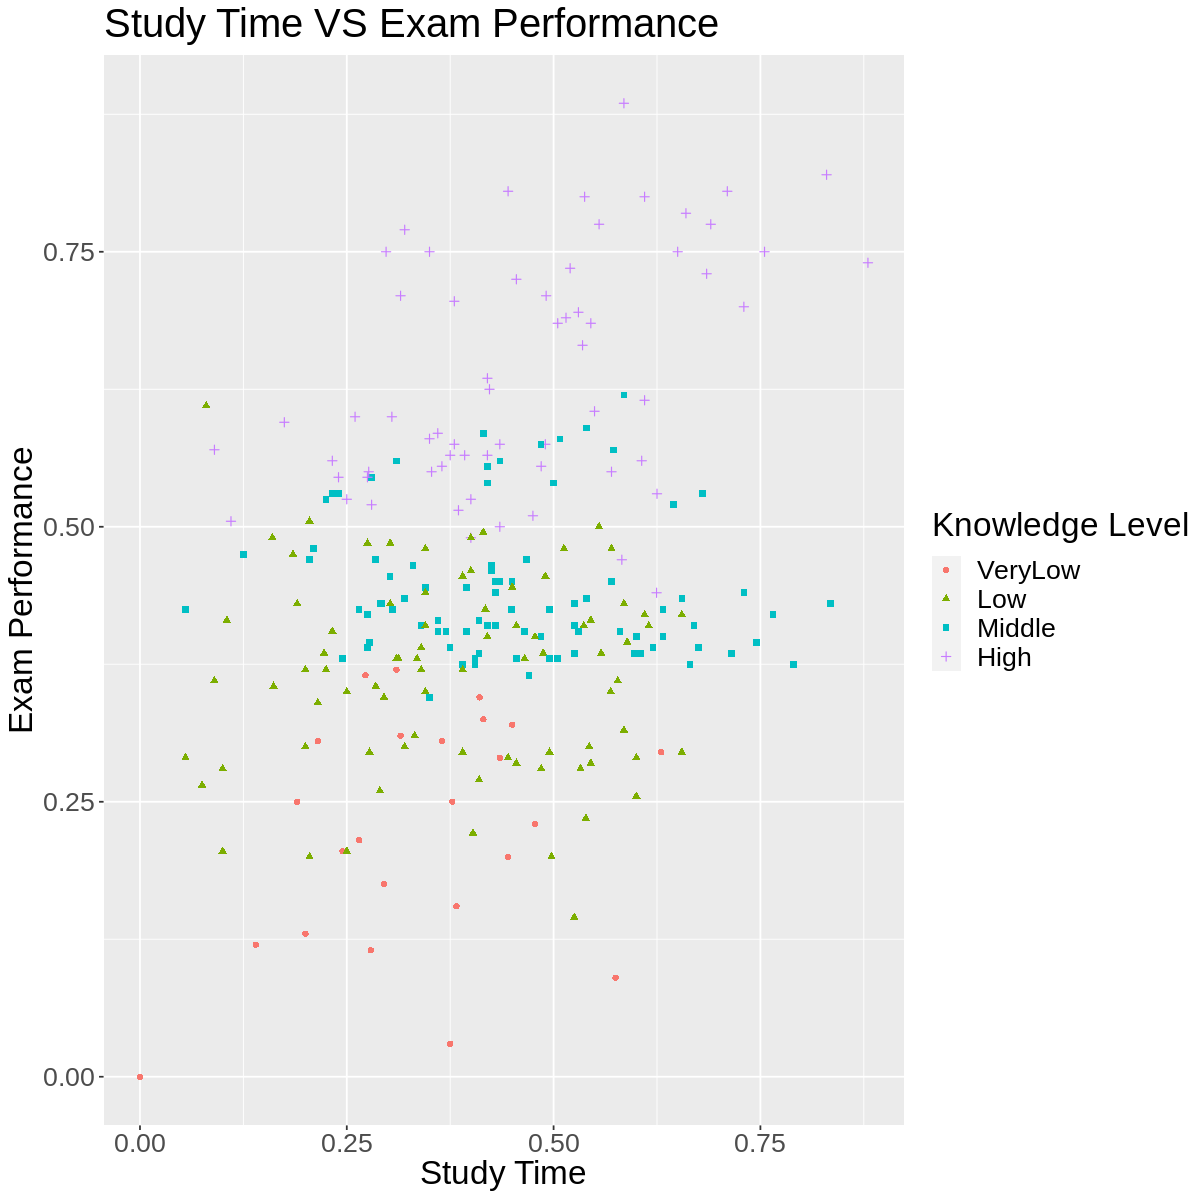

In [127]:
# plot study time VS exam performance
options(repr.plot.width = 10, repr.plot.height = 10)
timeVSperform_plot <- mutated_data %>%
                          ggplot(aes(x=TST, y=TEP))+
                          geom_point(aes(colour= UNS ,shape=UNS))+
                          labs(x="Study Time", 
                               y="Exam Performance", 
                               colour="Knowledge Level", 
                               shape="Knowledge Level")+
                          theme(text = element_text(size=20))+
                          ggtitle("Study Time VS Exam Performance")
timeVSperform_plot


## Methods 


We will use categorical analysis to classify knowledge level based on values from the STG, STR, LPR and PEG columns. We will split the dataset into a training group and a testing group for investigation and implement five-fold validation into the training group to determine the most accurate value of k for k-nearest neighbor modelling. 

We will mutate the columns to combine `STG` and `STR` (`TST`) and `LPR` and `PEG` (`TEP`) to find the mean of each pair of data to provide 
- ① an average degree of studying time on goal or related subject materials and 
- ② an average degree of exam performance with goal or related subject material. 



The two variables TST and TEP from mutation and sorting would be used in a k-nearest neighbor model to predict the knowledge level for a certain individual.


We will represent TST on the x-axis and TEP on the y-axis of a scatter plot, which will colour points by knowledge level, our categorical factor.


## Expected outcomes and significance 

We expect a positive correlation between studying time and exam performance, as well as between both variables and knowledge level.


Identifying relationships between studying time, exam performance, and knowledge level would provide insight for educators in terms of whether exams accurately represent students’ knowledge. Studying time would allow students to determine whether their studying methods are effective and allow them to adjust accordingly based on these relationships.


By answering our question, we can expand this project’s applications. Identifying reasons for exam performance or studying time not correlating with knowledge level would encourage educators and students to explore new methods for both: How could students study more effectively, and how could exams be more representative of students’ knowledge? Radically thinking, do exams reflect knowledge level at all?



In [128]:
nrow(data_tr)/(nrow(data_te)+nrow(data_tr))

[1] 0.6401985

In [129]:
glimpse(mutated_data)

Rows: 258
Columns: 8
$ STG <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.09, 0.10, 0.15, 0.20, 0.00, 0.18,…
$ SCG <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.15, 0.10, 0.02, 0.14, 0.00, 0.18,…
$ STR <dbl> 0.00, 0.10, 0.05, 0.15, 0.08, 0.40, 0.43, 0.34, 0.35, 0.50, 0.55,…
$ LPR <dbl> 0.00, 0.24, 0.25, 0.65, 0.98, 0.10, 0.29, 0.40, 0.72, 0.20, 0.30,…
$ PEG <dbl> 0.00, 0.90, 0.33, 0.30, 0.24, 0.66, 0.56, 0.01, 0.25, 0.85, 0.81,…
$ UNS <fct> VeryLow, High, Low, Middle, Low, Middle, Middle, VeryLow, Low, Hi…
$ TEP <dbl> 0.000, 0.570, 0.290, 0.475, 0.610, 0.380, 0.425, 0.205, 0.485, 0.…
$ TST <dbl> 0.000, 0.090, 0.055, 0.125, 0.080, 0.245, 0.265, 0.245, 0.275, 0.…


In [130]:
knowledge_recipe <- recipe(UNS~TEP+TST,data = mutated_data)
knowledge_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [139]:
knowledge_vfold <- vfold_cv(mutated_data, v = 5, strata = UNS)
gridvals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
knn_tune <-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
      set_mode("classification")
knn_results <- workflow() %>%
      add_recipe(knowledge_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = knowledge_vfold, grid = gridvals) %>%
      collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5775543,5,0.010277457,Model01
1,roc_auc,hand_till,0.6945924,5,0.011739951,Model01
2,accuracy,multiclass,0.5775543,5,0.010277457,Model02
2,roc_auc,hand_till,0.7616689,5,0.013577900,Model02
3,accuracy,multiclass,0.6000361,5,0.021946840,Model03
3,roc_auc,hand_till,0.7920770,5,0.009632981,Model03
4,accuracy,multiclass,0.6038822,5,0.022934103,Model04
4,roc_auc,hand_till,0.8445817,5,0.014180114,Model04
5,accuracy,multiclass,0.6473332,5,0.021931129,Model05


[1] 11

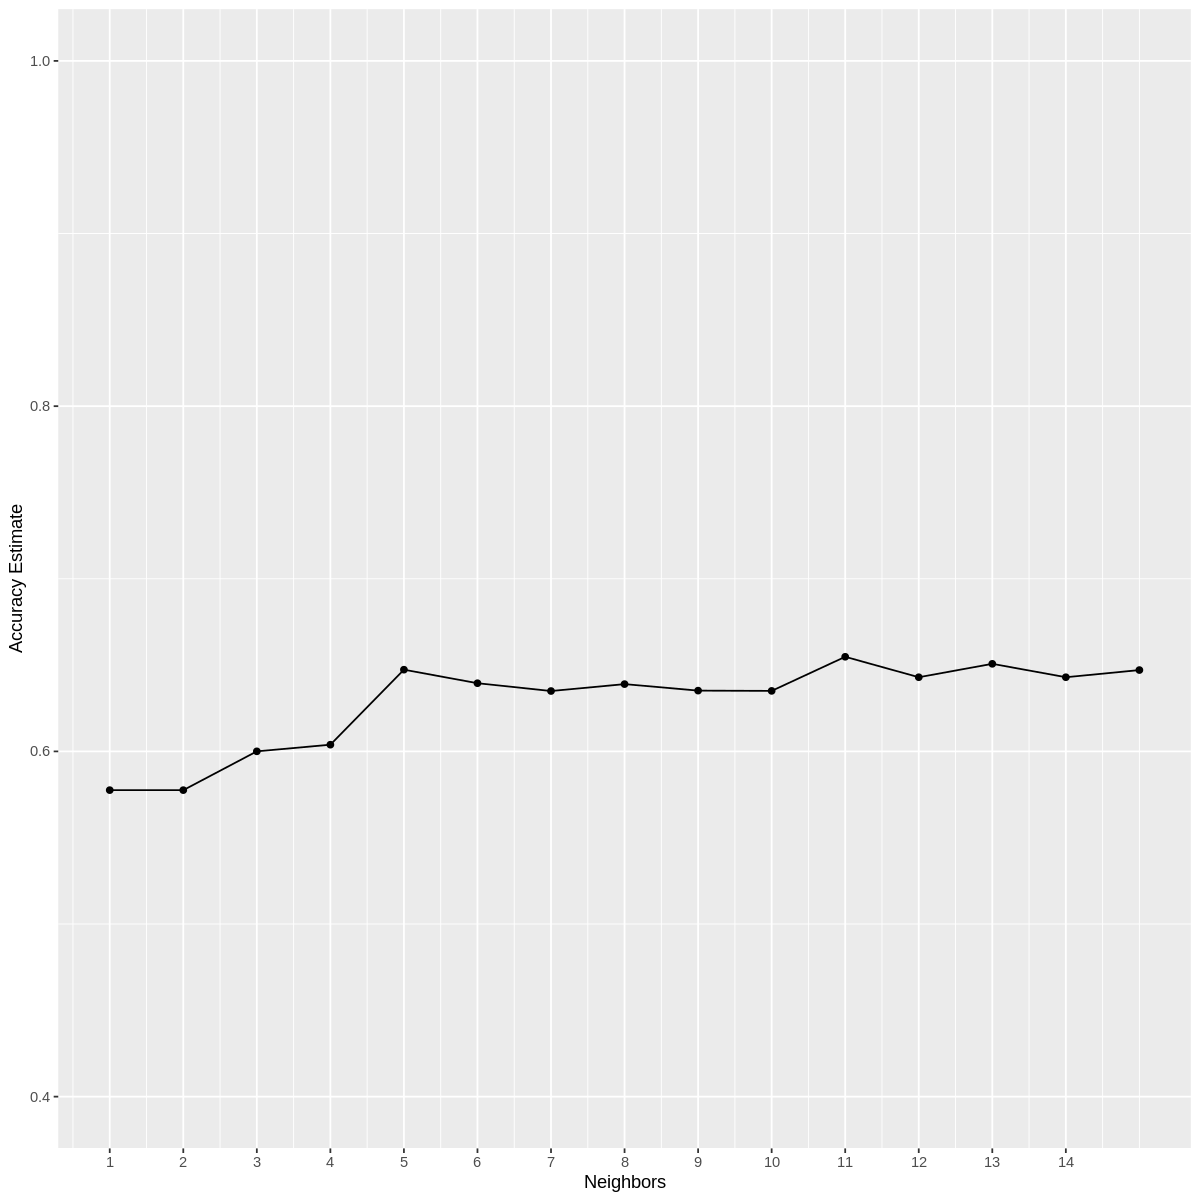

In [146]:
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracies_max <- accuracies %>% arrange(desc(mean)) %>%slice(1) %>% select(neighbors) %>%as.integer()
accuracies_max
accuracy_versus_k

In [147]:
knowledge_mutated_testing <- data_te %>%
                mutate(TEP = (LPR + PEG)/2) %>%
                mutate(TST = (STG + STR)/2) 
knowledge_mutated_testing

STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.10,0.50,0.26,0.05,VeryLow,0.155,0.250
0.05,0.05,0.55,0.60,0.14,Low,0.370,0.300
0.08,0.18,0.63,0.60,0.85,High,0.725,0.355
0.20,0.20,0.68,0.67,0.85,High,0.760,0.440
0.22,0.22,0.90,0.30,0.90,High,0.600,0.560
0.14,0.14,0.70,0.50,0.30,Low,0.400,0.420
0.16,0.16,0.80,0.50,0.50,Middle,0.500,0.480
0.12,0.12,0.75,0.68,0.15,Low,0.415,0.435
0.20,0.20,0.88,0.77,0.80,High,0.785,0.540


In [148]:
knowledge_best <-nearest_neighbor(weight_func = "rectangular", neighbors = accuracies_max) %>%
        set_engine("kknn") %>%
      set_mode("classification")

In [149]:
knowledge_model <- workflow() %>%
      add_recipe(knowledge_recipe) %>%
      add_model(knowledge_best) %>%
      fit(data = mutated_data)
knowledge_predict <- predict(knowledge_model,new_data = knowledge_mutated_testing) %>% bind_cols(knowledge_mutated_testing)
knowledge_predict


.pred_class,STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
VeryLow,0.00,0.10,0.50,0.26,0.05,VeryLow,0.155,0.250
Low,0.05,0.05,0.55,0.60,0.14,Low,0.370,0.300
High,0.08,0.18,0.63,0.60,0.85,High,0.725,0.355
High,0.20,0.20,0.68,0.67,0.85,High,0.760,0.440
High,0.22,0.22,0.90,0.30,0.90,High,0.600,0.560
Middle,0.14,0.14,0.70,0.50,0.30,Low,0.400,0.420
Low,0.16,0.16,0.80,0.50,0.50,Middle,0.500,0.480
Middle,0.12,0.12,0.75,0.68,0.15,Low,0.415,0.435
High,0.20,0.20,0.88,0.77,0.80,High,0.785,0.540


In [153]:
knowledge_prediction_accuracy<- knowledge_predict %>% metrics(truth = UNS, estimate = .pred_class)
knowledge_matrix <- knowledge_predict %>% conf_mat(truth = UNS, estimate = .pred_class)
knowledge_prediction_accuracy
knowledge_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6965517
kap,multiclass,0.5890764


          Truth
Prediction VeryLow Low Middle High
   VeryLow      21   3      0    0
   Low           5  29      9    0
   Middle        0  13     14    2
   High          0   1     11   37